# Forest Fire Detection with transfer learning using ResNet50

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.models import load_model
from keras.applications import ResNet50
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dir = "data/Training"
test_dir = "data/Test"

RESNET_SIZE = 224

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(RESNET_SIZE, RESNET_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                subset='training',
                                                class_mode='binary')

val_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(RESNET_SIZE, RESNET_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                subset='validation',
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(RESNET_SIZE, RESNET_SIZE),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

Found 29547 images belonging to 2 classes.
Found 9848 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [5]:
transfer_model = ResNet50(include_top=True,
                        weights="imagenet",
                        classes=1000)
input = transfer_model.inputs

102973440/102967424 [==============================] - 7s 0us/step


In [6]:
transfer_model.summary()

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

In [8]:
x = transfer_model.get_layer("avg_pool").output
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(1024, activation="relu")(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier = Model(input, output_layer)

for layer in classifier.layers[:-5]:
    layer.trainable = False

classifier.summary()

[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]    

In [9]:
classifier.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(lr=0.001),
                metrics=["accuracy"])

In [11]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='models/resnet50_model.h5', save_best_only=True),
]

history = classifier.fit(train_generator, 
                        epochs=5, 
                        batch_size=40,
                        validation_data=val_generator,
                        callbacks=callbacks)

Epoch 1/5
1478/1478 [==============================] - 2173s 1s/step - loss: 0.2421 - accuracy: 0.9158 - val_loss: 0.0670 - val_accuracy: 0.9821
Epoch 2/5
1478/1478 [==============================] - 1919s 1s/step - loss: 0.1738 - accuracy: 0.9381 - val_loss: 0.1473 - val_accuracy: 0.9472
Epoch 3/5
1478/1478 [==============================] - 1838s 1s/step - loss: 0.1547 - accuracy: 0.9441 - val_loss: 0.0895 - val_accuracy: 0.9646
Epoch 4/5
1478/1478 [==============================] - 1851s 1s/step - loss: 0.1495 - accuracy: 0.9471 - val_loss: 0.2154 - val_accuracy: 0.9141
Epoch 5/5
1478/1478 [==============================] - 1942s 1s/step - loss: 0.1460 - accuracy: 0.9482 - val_loss: 0.0780 - val_accuracy: 0.9676


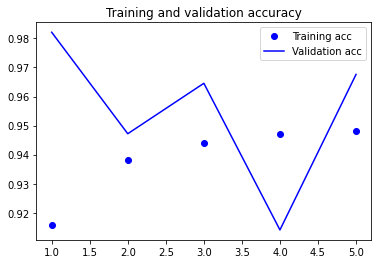

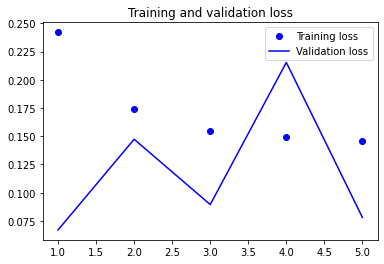

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [51]:
classifier.save("models/resnet50_model.h5")

In [12]:
result = classifier.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

431/431 [==============================] - 407s 945ms/step - loss: 0.8416 - accuracy: 0.6393
Test loss: 0.8416192531585693, Test accuracy: 0.6393176317214966
